# DATA & LIBRARIES

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Police.csv")
df.head()

,state,stop_date,stop_time,county_name,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district
0,RI,2005-01-04,12:55,NaN,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4
1,RI,2005-01-23,23:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3
2,RI,2005-02-17,04:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4
3,RI,2005-02-20,17:15,NaN,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1
4,RI,2005-02-24,01:20,NaN,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3


# DATA PREPROCESSING

In [49]:
# Overview about missing values to determine which columns/rows could be dropped
df.isna().sum()

state                     0
stop_date                 0
stop_time                 0
county_name           91741
driver_gender          5205
driver_race            5202
violation_raw          5202
violation              5202
search_conducted          0
search_type           88434
stop_outcome           5202
is_arrested            5202
stop_duration          5202
drugs_related_stop        0
district                  0
dtype: int64

In [50]:
#setting combination of date and time as index to improve dataset readability
combined = df.stop_date.str.cat(df.stop_time, sep=' ')
df["stop_datetime"] = pd.to_datetime(combined)
df.set_index("stop_datetime", inplace = True)

In [51]:
#drop useless columns and drop driver_gender rows with missing values
df.drop(columns=["state","county_name","search_type","stop_date","stop_time"], inplace = True)
df.dropna(subset=["driver_gender"], inplace = True)

#changing type to boolean for later analysis
df["search_conducted"] = df.search_conducted.astype(bool)
df["is_arrested"] = df.is_arrested.astype(bool)

In [85]:
#PREPROCESSING DONE
df.head()

,driver_gender,driver_race,violation_raw,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district,stop_minutes
stop_datetime,,,,,,,,,,,
2005-01-04 12:55:00,M,White,Equipment/Inspection Violation,Equipment,False,Citation,False,0-15 Min,False,Zone X4,7.5
2005-01-23 23:15:00,M,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,Zone K3,7.5
2005-02-17 04:15:00,M,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,Zone X4,7.5
2005-02-20 17:15:00,M,White,Call for Service,Other,False,Arrest Driver,True,16-30 Min,False,Zone X1,22.5
2005-02-24 01:20:00,F,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,Zone X3,7.5


# DATA ANALYSIS

## Overview

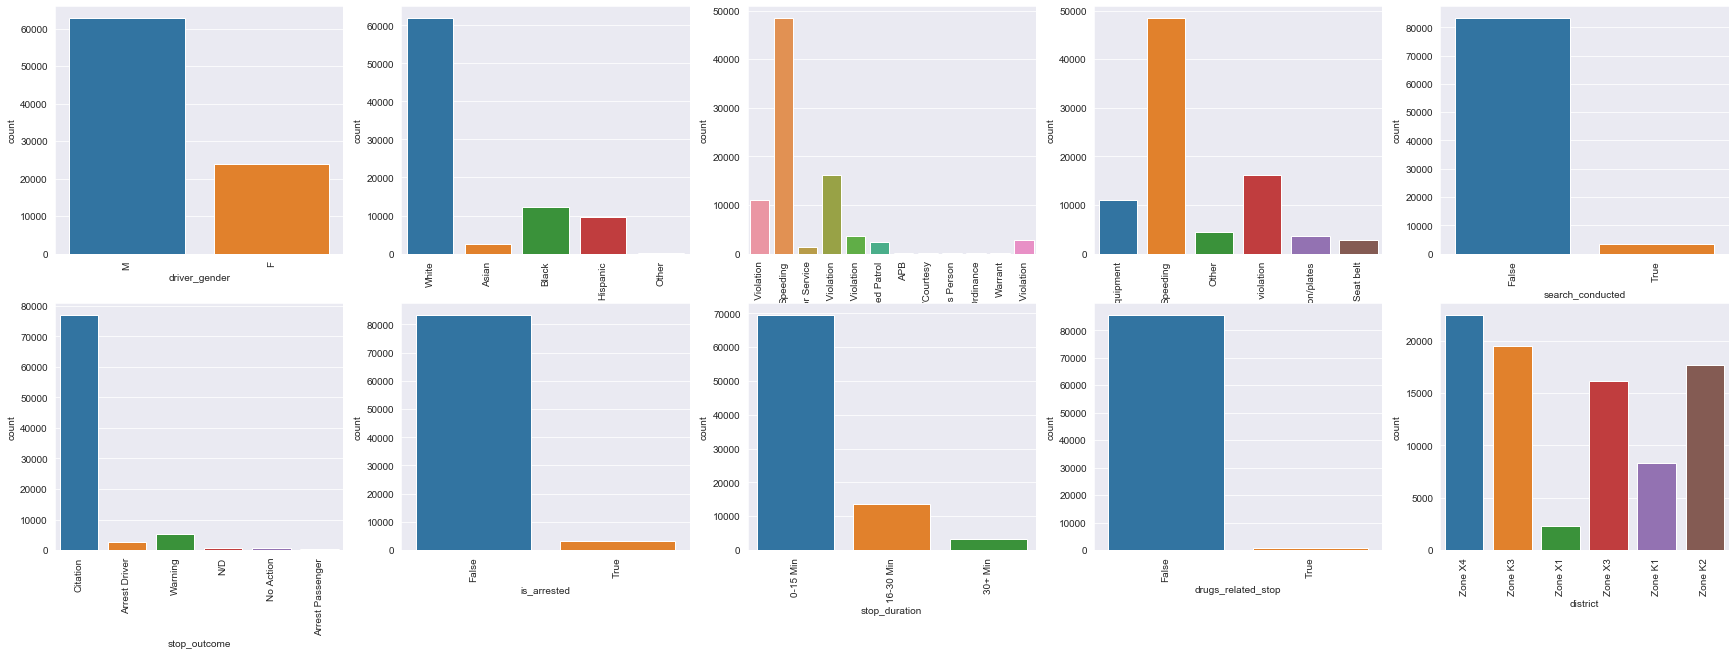

In [53]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10))
for variable, subplot in zip(df.columns, ax.flat):
    sns.countplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

## Gender differences?

In [54]:
# Violation distribution by gender
print(df[df.driver_gender == "F"].violation.value_counts(normalize=True))

Speeding               0.658114
Moving violation       0.138218
Equipment              0.105199
Registration/plates    0.044418
Other                  0.029738
Seat belt              0.024312
Name: violation, dtype: float64


In [55]:
print(df[df.driver_gender == "M"].violation.value_counts(normalize=True))

Speeding               0.522243
Moving violation       0.206144
Equipment              0.134158
Other                  0.058985
Registration/plates    0.042175
Seat belt              0.036296
Name: violation, dtype: float64


Most occuring violence is speeding for both genders. 

Suppose you are caught for speeding. Are there different treatments depending on gender?

In [56]:
df[(df.driver_gender== "F")&(df.violation=="Speeding")].stop_outcome.value_counts(normalize=True)

Citation            0.952192
Warning             0.040074
Arrest Driver       0.005752
N/D                 0.000959
Arrest Passenger    0.000639
No Action           0.000383
Name: stop_outcome, dtype: float64

In [57]:
df[(df.driver_gender== "M")&(df.violation=="Speeding")].stop_outcome.value_counts(normalize=True)

Citation            0.944595
Warning             0.036184
Arrest Driver       0.015895
Arrest Passenger    0.001281
No Action           0.001068
N/D                 0.000976
Name: stop_outcome, dtype: float64

-> There seems to be no significant difference in treatment!

During a traffic stop, police investigate the car if they have suspicions. Does gender have an influence here?

In [58]:
df.groupby("driver_gender").search_conducted.mean()

driver_gender
F    0.019181
M    0.045426
Name: search_conducted, dtype: float64

->  Police tend to control men with a higher probability. (Be careful with causality

Further investigation by adding a second factor [type of violation]:

In [59]:
df.groupby(["driver_gender","violation"]).search_conducted.mean()

driver_gender  violation          
F              Equipment              0.039984
               Moving violation       0.039257
               Other                  0.041018
               Registration/plates    0.054924
               Seat belt              0.017301
               Speeding               0.008309
M              Equipment              0.071496
               Moving violation       0.061524
               Other                  0.046191
               Registration/plates    0.108802
               Seat belt              0.035119
               Speeding               0.027885
Name: search_conducted, dtype: float64

-> Men's cars are more often investigated regardless the type of violation!

If the car is investigated, how many drivers are getting arrested (in %) ?

In [60]:
df[(df.search_conducted==True)].groupby("driver_gender").is_arrested.value_counts(normalize=True)

driver_gender  is_arrested
F              False          0.609649
               True           0.390351
M              False          0.662925
               True           0.337075
Name: is_arrested, dtype: float64

If the car is inspected, women are more likely to be arrested than men. This could indicate that women are only stopped in the presence of severe conspicuousness, while men are generally checked more frequently.

## Race differences?

In [61]:
df.groupby("driver_race").violation.value_counts(normalize=True)

driver_race  violation          
Asian        Speeding               0.678108
             Moving violation       0.133110
             Equipment              0.091670
             Other                  0.046463
             Registration/plates    0.028882
             Seat belt              0.021766
Black        Speeding               0.411070
             Moving violation       0.239316
             Equipment              0.175254
             Registration/plates    0.070737
             Other                  0.066504
             Seat belt              0.037118
Hispanic     Speeding               0.335252
             Moving violation       0.244783
             Equipment              0.222885
             Registration/plates    0.079778
             Other                  0.064254
             Seat belt              0.053048
Other        Speeding               0.630189
             Moving violation       0.218868
             Equipment              0.052830
             Other    

In [62]:
df.groupby("driver_race").search_conducted.mean()

driver_race
Asian       0.020511
Black       0.066992
Hispanic    0.061478
Other       0.011321
White       0.029643
Name: search_conducted, dtype: float64

In [63]:
df.groupby(["driver_race","violation"]).search_conducted.mean()

driver_race  violation          
Asian        Equipment              0.018265
             Moving violation       0.047170
             Other                  0.036036
             Registration/plates    0.057971
             Seat belt              0.076923
             Speeding               0.011111
Black        Equipment              0.086856
             Moving violation       0.074490
             Other                  0.034272
             Registration/plates    0.108170
             Seat belt              0.052632
             Speeding               0.053663
Hispanic     Equipment              0.071033
             Moving violation       0.065939
             Other                  0.054400
             Registration/plates    0.105670
             Seat belt              0.048450
             Speeding               0.044772
Other        Equipment              0.000000
             Moving violation       0.017241
             Other                  0.000000
             Registrat

## Datetime differences?

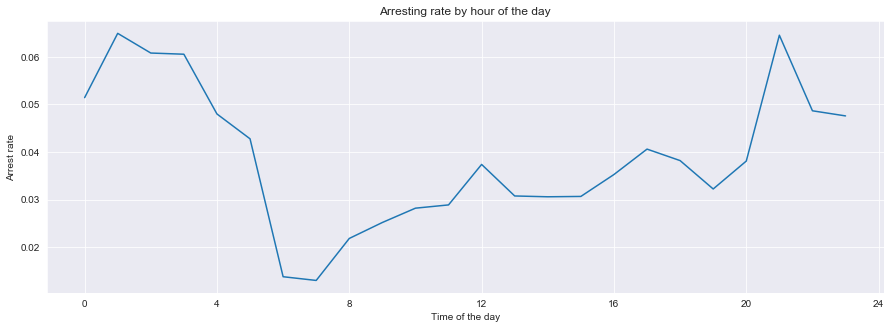

In [64]:
#Plot arresting quote by hour of the day
plt.figure(figsize=(15,5))
sns.set_style("darkgrid")
df.groupby(df.index.hour).is_arrested.mean().plot()
plt.title("Arresting rate by hour of the day")
plt.xlabel("Time of the day")
plt.ylabel("Arrest rate")
plt.xticks(range(0,25,4))
plt.show()

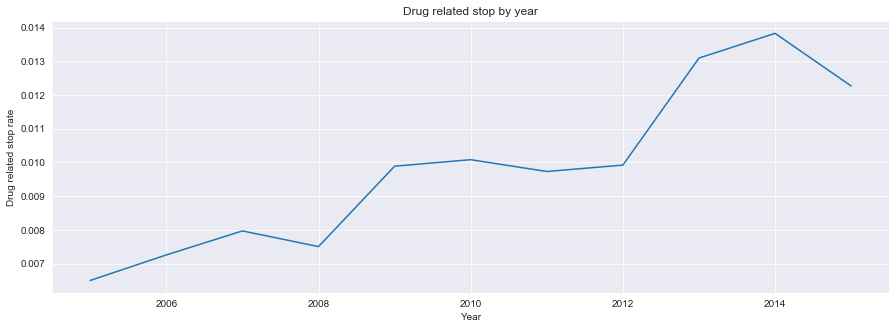

In [65]:
plt.figure(figsize=(15,5))
sns.set_style("darkgrid")
df.groupby(df.index.year).drugs_related_stop.mean().plot()
plt.title("Drug related stop by year")
plt.xlabel("Year")
plt.ylabel("Drug related stop rate")
plt.show()

Imagine your car is stopped for inspection. How long is your expected stop duration (depending on violation)?

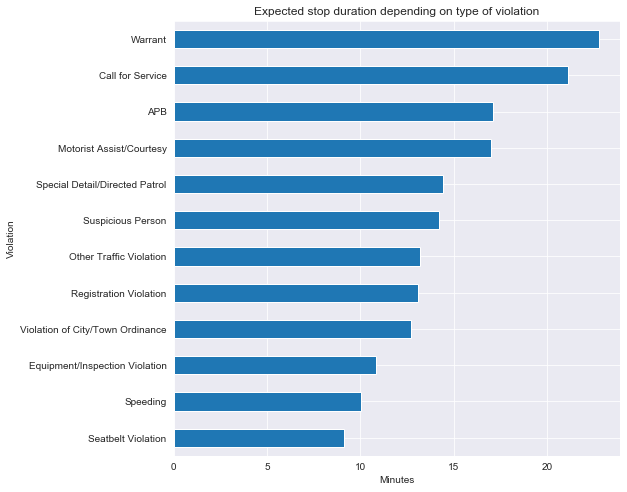

In [66]:
#transform stop duration from categorical to average value
mapping = {"0-15 Min": 7.5,"16-30 Min" : 22.5, '30+ Min': 42.5}
df["stop_minutes"] = df.stop_duration.map(mapping)

# PLOT avg. stop duration depending on violation
plt.figure(figsize=(8,8))
df.groupby("violation_raw").stop_minutes.mean().sort_values().plot.barh()
plt.title("Expected stop duration depending on type of violation")
plt.xlabel("Minutes")
plt.ylabel("Violation")
plt.show()

# Additional dataset: Weather

Does weather have influence on police decisions? 

Lets explore this by loading dataset with the corresponding weather in Rhode island at the time of the police stops!

## Overview Dataset

In [86]:
weather = pd.read_csv("weather.csv")
weather.head()

,STATION,DATE,TAVG,TMIN,TMAX,AWND,WSF2,WT01,WT02,WT03,...,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22
0,USW00014765,2005-01-01,44.0,35,53,8.95,25.1,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014765,2005-01-02,36.0,28,44,9.40,14.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2,USW00014765,2005-01-03,49.0,44,53,6.93,17.0,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,USW00014765,2005-01-04,42.0,39,45,6.93,16.1,1.0,NaN,NaN,...,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,USW00014765,2005-01-05,36.0,28,43,7.83,17.0,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN


In [68]:
#PREPROCESSING
#only keep our columns of interest
weather = weather[["DATE","TMIN","TMAX"]]
print(weather.isna().sum())

weather["DATE"] = pd.to_datetime(weather.DATE)
weather.set_index("DATE", inplace = True)

# Transforming tempeature: fahrenheit to celsius
weather["TMIN"]= (weather["TMIN"]-32)*5/9
weather["TMAX"]= (weather["TMAX"]-32)*5/9

weather.head()

DATE    0
TMIN    0
TMAX    0
dtype: int64


C:\Users\alexm\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\alexm\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\alexm\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

,TMIN,TMAX
DATE,,
2005-01-01,1.666667,11.666667
2005-01-02,-2.222222,6.666667
2005-01-03,6.666667,11.666667
2005-01-04,3.888889,7.222222
2005-01-05,-2.222222,6.111111


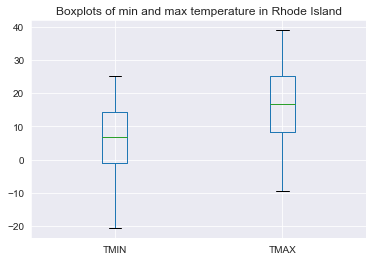

In [69]:
weather[["TMIN","TMAX"]].plot.box()
plt.title("Boxplots of min and max temperature in Rhode Island")
plt.show()

## Analysis of police activity with additional Information about weather

In [82]:
#Merging datasets on the specific date

combi = df.merge(weather, left_on = df.index.date, right_on = weather.index.date)
combi.head()

,key_0,driver_gender,driver_race,violation_raw,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district,stop_minutes,TMIN,TMAX
0,2005-01-04,M,White,Equipment/Inspection Violation,Equipment,False,Citation,False,0-15 Min,False,Zone X4,7.5,3.888889,7.222222
1,2005-01-23,M,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,Zone K3,7.5,-15.000000,-2.222222
2,2005-02-17,M,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,Zone X4,7.5,-1.666667,3.888889
3,2005-02-20,M,White,Call for Service,Other,False,Arrest Driver,True,16-30 Min,False,Zone X1,22.5,-7.777778,1.111111
4,2005-02-24,F,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,Zone X3,7.5,-7.777778,-1.666667


Now the final question is: Do police activity differ on bad weather days?

How do we define bad weather? My suggestion is: If the maximum temperature was only 5 degrees Celsius, I would call this a cold and uncomfortable day!

In [88]:
badweatherdays = combi[combi.TMAX < 5]
badweatherdays

,key_0,driver_gender,driver_race,violation_raw,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district,stop_minutes,TMIN,TMAX
1,2005-01-23,M,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,Zone K3,7.5,-15.000000,-2.222222
2,2005-02-17,M,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,Zone X4,7.5,-1.666667,3.888889
3,2005-02-20,M,White,Call for Service,Other,False,Arrest Driver,True,16-30 Min,False,Zone X1,22.5,-7.777778,1.111111
4,2005-02-24,F,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,Zone X3,7.5,-7.777778,-1.666667
1504,2005-11-23,M,Black,Equipment/Inspection Violation,Equipment,False,Citation,False,0-15 Min,False,Zone X3,7.5,-4.444444,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86509,2015-12-30,F,White,Speeding,Speeding,False,Warning,False,0-15 Min,False,Zone X4,7.5,-2.777778,1.666667
86510,2015-12-30,M,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,Zone X4,7.5,-2.777778,1.666667
86511,2015-12-30,F,White,Speeding,Speeding,False,Warning,False,0-15 Min,False,Zone X1,7.5,-2.777778,1.666667
86512,2015-12-30,M,Hispanic,Seatbelt Violation,Seat belt,False,Citation,False,0-15 Min,False,Zone X3,7.5,-2.777778,1.666667


**Weather influence on police investigation**

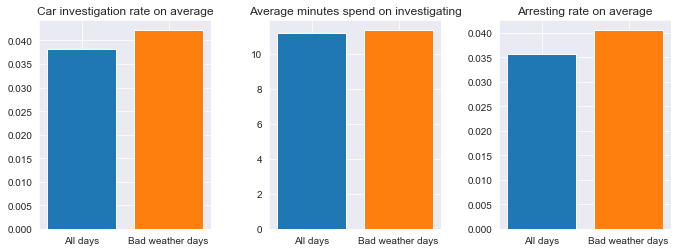

In [141]:
fig,ax  = plt.subplots(1,3, figsize=(10,4))

fig.tight_layout(pad=3)

ax[0].bar("All days",combi.search_conducted.mean())
ax[0].bar("Bad weather days", badweatherdays.search_conducted.mean())
ax[0].set(title = "Car investigation rate on average")


ax[1].bar("All days",combi.stop_minutes.mean())
ax[1].bar("Bad weather days", badweatherdays.stop_minutes.mean())
ax[1].set(title="Average minutes spend on investigating")

ax[2].bar("All days",combi.is_arrested.mean())
ax[2].bar("Bad weather days", badweatherdays.is_arrested.mean())
ax[2].set(title="Arresting rate on average")

plt.show()

As we can see, there is only very little difference. Investigation rate and arresting rate is higher on bad weather days, but the conclusion should be carefully done as many other factors could play a role here.